In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020158,2025-10-29T00:15:00,St. Louis Blues,Detroit Red Wings,0.5611,0.4040,0.7829,2,5,False,True,False
1,2025020307,2025-11-19T00:00:00,Toronto Maple Leafs,St. Louis Blues,0.3990,0.5598,0.6204,3,2,True,False,True


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          300      0.5433 0.2530   0.6996 0.5231   0.5233
Totals (Over/Under)  300      0.4867 0.2504   0.6939 0.5184   0.5267
Asian Handicap       300      0.7700 0.1816   0.5503 0.5225   0.7667


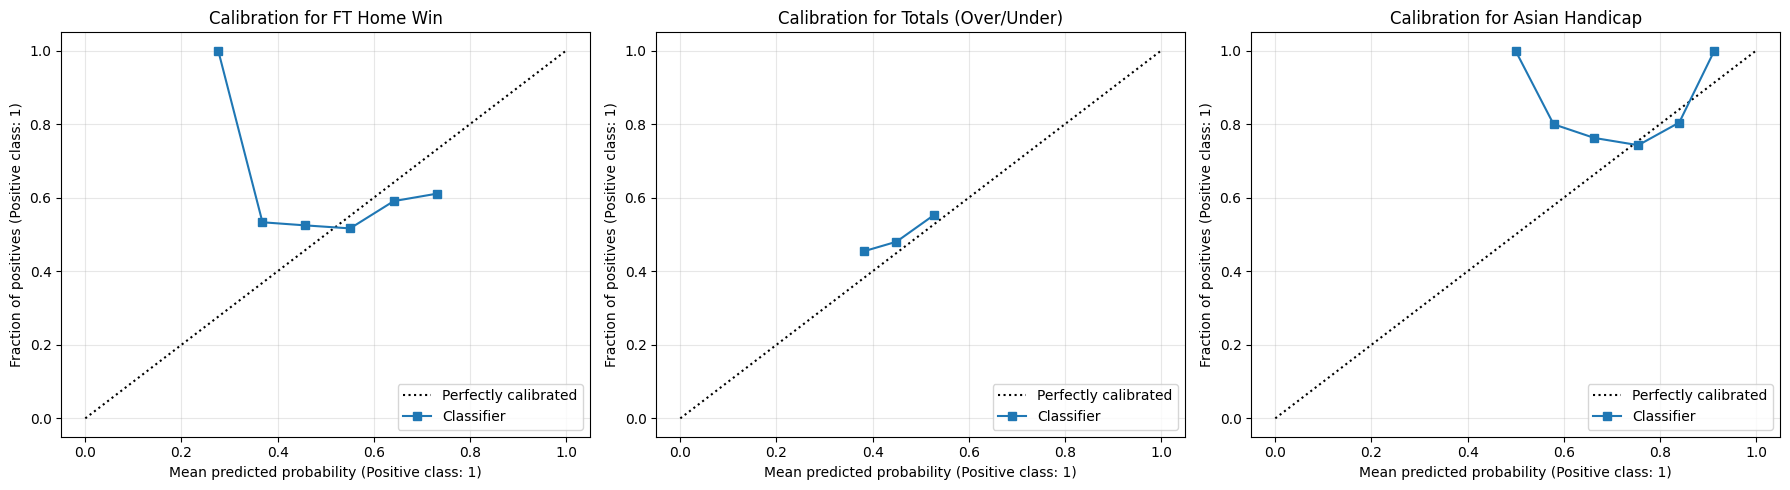

In [5]:
# Evaluate everything
_ = u.evaluate_calibration(df=df, n_bins=10)

=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          160      0.5563 0.2466   0.6856 0.5620   0.5250
Totals (Over/Under)  160      0.5000 0.2504   0.6939 0.5311   0.5000
Asian Handicap       160      0.7812 0.1790   0.5426 0.4998   0.7750


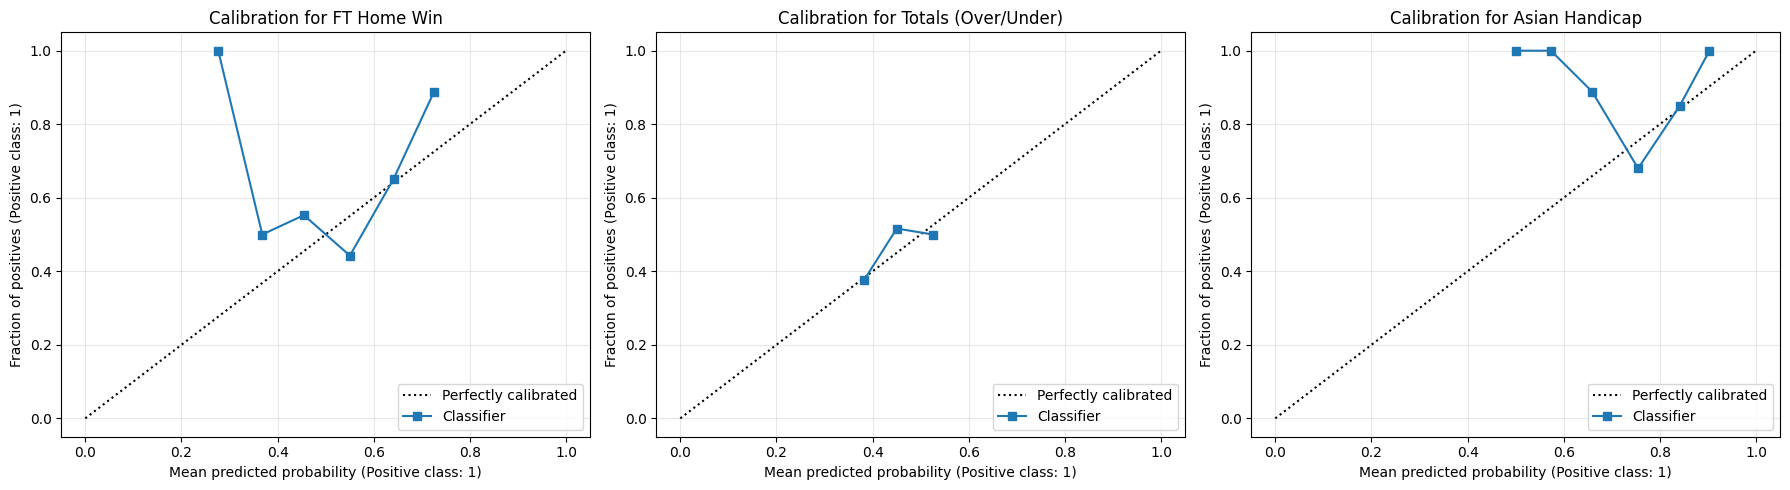

In [6]:
# Evaluate matches only after major bugfix
after_bug_df = df[df["start_time_utc"]>="2025-10-29 15:00:00"].copy()
_ = u.evaluate_calibration(df=after_bug_df, n_bins=10)

## NBA

In [7]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=8.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,0022500253,2025-11-19T03:30:00,Los Angeles Lakers,Utah Jazz,0.8396,0.7046,0.9388,140,126,True,True,True
1,0022500244,2025-11-18T00:30:00,Miami Heat,New York Knicks,0.6021,0.4706,0.7951,115,113,True,True,True


=== Evaluation Summary ===
                      n  prevalence  brier  logloss    auc  acc@0.5
metric                                                             
FT Home Win          23      0.5652 0.1867   0.5463 0.7846   0.6957
Totals (Over/Under)  23      0.5652 0.2417   0.6791 0.5538   0.5652
Asian Handicap       23      0.7826 0.1504   0.4589 0.7444   0.8261


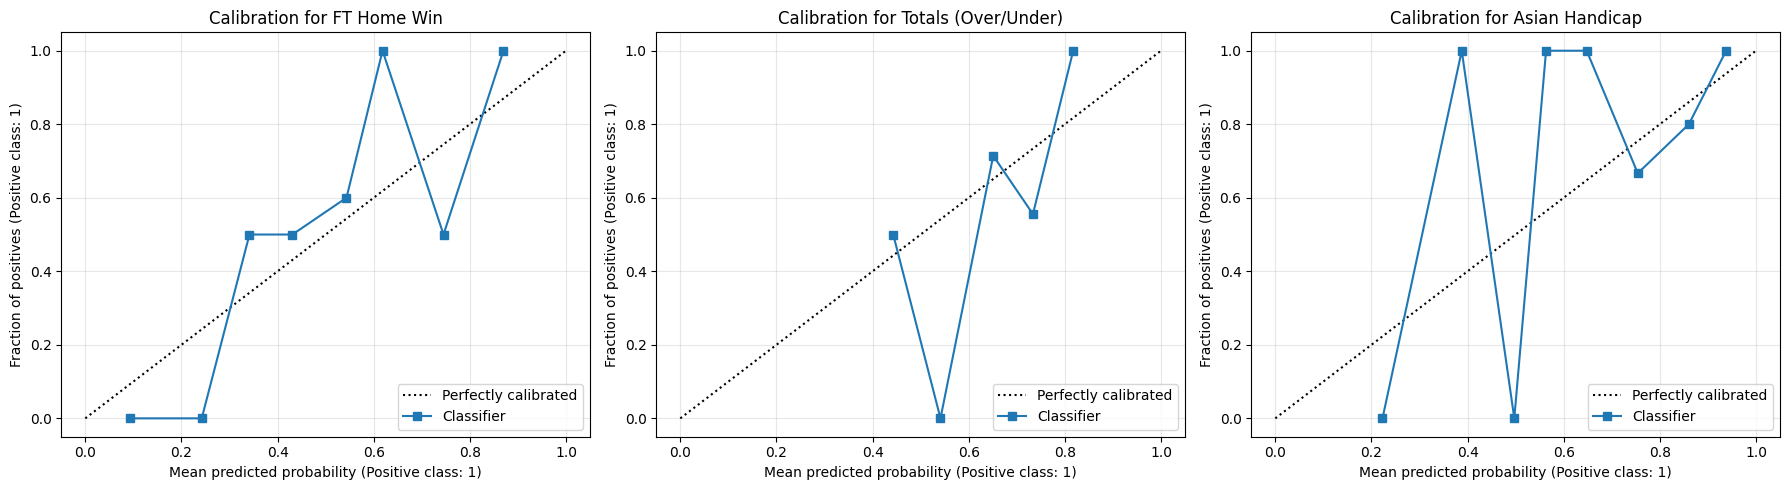

In [8]:
_ = u.evaluate_calibration(df=df, n_bins=10)